# Package

In [1]:
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

print('tf version: ', tf.__version__)

tf version:  2.10.0


# Prepare dataset

In [3]:
splits, info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, 
                   with_info='True', data_dir='./cifar10', download=False)

# splits, info = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True, 
#                    with_info='True', data_dir='./fashion_mnist', download=False)


Metal device set to: Apple M2


2022-10-20 07:59:05.790354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 07:59:05.790928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
train_data, test_data = splits

In [7]:
train_num_examples = info.splits['train'].num_examples
test_num_examples = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes
image_shape = info.features['image'].shape
image_input_shape = (image_shape[0], image_shape[1])
image_channels = image_shape[-1]

print('training_examples: ', train_num_examples)
print('test_examples: ', test_num_examples)
print('nums of classes: ', num_classes)
print('image shape: ', image_shape)

training_examples:  50000
test_examples:  10000
nums of classes:  10
image shape:  (32, 32, 3)


In [10]:
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    noise_factor = 0.3
    factor = noise_factor * tf.random.normal(shape=image.shape)
    
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
    
    return image_noisy, image

In [11]:
batch_size = 64

train_dataset_batches = train_data.map(format_image).shuffle(1024).batch(batch_size).repeat()
test_dataset_batches = test_data.map(format_image).batch(batch_size)

# Define the model

In [12]:
def encoder(inputs):
    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    return x

In [13]:
def bottle_neck(inputs):
    
    bottle_neck_output = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='SAME')(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3),
                                                   activation='sigmoid', padding='same')(bottle_neck_output)

    return bottle_neck_output, encoder_visualization

In [14]:
def decoder(inputs):
    x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='SAME')(inputs)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='SAME')(x)
    
    return x

In [15]:
def cnn_auto_encoder():
    inputs = tf.keras.layers.Input(shape=image_shape)
    encoder_output = encoder(inputs)
    bottle_neck_output, encoder_visualization = bottle_neck(encoder_output)
    
    decoder_output = decoder(bottle_neck_output)
    
    model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    
    return model, encoder_model

In [16]:
cnn_model, cnn_encoder_model = cnn_auto_encoder()
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

In [17]:
cnn_model.load_weights('./cnn_model_weights.h5')

In [18]:
cnn_encoder_model.load_weights('./cnn_encoder_weights.h5')

In [15]:
train_steps = train_num_examples // batch_size
valid_steps = test_num_examples // batch_size

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])

conv_model_history = cnn_model.fit(train_dataset_batches, 
                                   steps_per_epoch=train_steps, 
                                   validation_data=test_dataset_batches, 
                                   validation_steps=valid_steps, epochs=40)

Epoch 1/40
781/781 [==============================] - 30s 32ms/step - loss: 0.0152 - accuracy: 0.6345 - val_loss: 0.0096 - val_accuracy: 0.7255
Epoch 2/40
781/781 [==============================] - 22s 28ms/step - loss: 0.0085 - accuracy: 0.7226 - val_loss: 0.0077 - val_accuracy: 0.7297
Epoch 3/40
781/781 [==============================] - 22s 28ms/step - loss: 0.0073 - accuracy: 0.7306 - val_loss: 0.0069 - val_accuracy: 0.7434
Epoch 4/40
781/781 [==============================] - 22s 28ms/step - loss: 0.0067 - accuracy: 0.7353 - val_loss: 0.0071 - val_accuracy: 0.7412
Epoch 5/40
781/781 [==============================] - 22s 28ms/step - loss: 0.0063 - accuracy: 0.7394 - val_loss: 0.0061 - val_accuracy: 0.7180
Epoch 6/40
781/781 [==============================] - 22s 28ms/step - loss: 0.0061 - accuracy: 0.7406 - val_loss: 0.0060 - val_accuracy: 0.7441
Epoch 7/40
781/781 [==============================] - 22s 29ms/step - loss: 0.0059 - accuracy: 0.7428 - val_loss: 0.0057 - val_accuracy:

In [28]:
def display_one_row(disp_images, offset, shape=image_input_shape):
    '''Display sample outputs in one row.'''
    for idx, noisy_image in enumerate(disp_images):
        plt.subplot(4, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        # noisy_image = np.reshape(noisy_image, shape)
        plt.imshow(noisy_image, cmap='gray')



def display_results(original_images, disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(original_images, 0)
    display_one_row(disp_input_images, 10, shape=image_input_shape)
    display_one_row(disp_encoded, 20, shape=enc_shape)
    display_one_row(disp_predicted, 30, shape=image_input_shape)
    

1/1 [==============================] - 0s 14ms/step


2022-10-20 08:14:40.456995: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


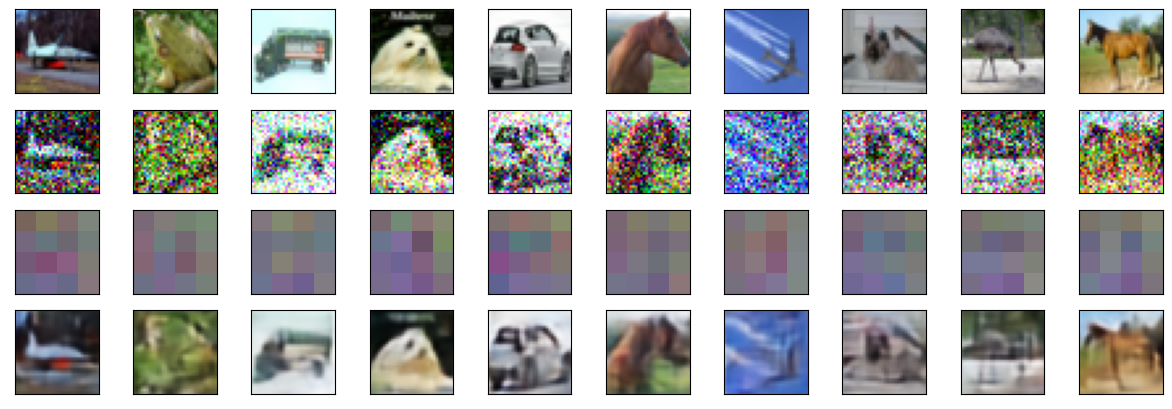

In [29]:
# take 1 batch of the dataset
test_dataset = test_dataset_batches.take(1)

# take the input images and put them in a list
output_samples = []

original_images = []
for input_image, image in tfds.as_numpy(test_dataset):
    
    output_samples = input_image
    original_images = image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10,) + image_shape)

# get the encoder ouput
encoded = cnn_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = cnn_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(original_images[idxs], conv_output_samples, encoded, predicted, enc_shape=(4,4))
plt.savefig('conv1.jpg', bbox_inches='tight')